# Engenharia e seleção de features

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib #Para salvar o modelo 
from sklearn.experimental import enable_halving_search_cv # Necessário para importar
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import HalvingRandomSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint # Para a distribuição de parâmetros
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import pickle
import os, random
import utils
from functools import partial



2025-10-21 10:58:12.303632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 10:58:12.333524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 10:58:13.306136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Observações:

1 - As bibliotecas que serão usadas neste projeto possuem fontes múltiplas de aleatoriedade. Por isso ressalta-se os seguintes pontos abaixo:

- numpy, random (do Python), e tensorflow usam geradores diferentes.

    - Fixar random_state em HalvingRandomSearchCV só controla o sorteio dos hiperparâmetros, não o comportamento interno da rede.

- TensorFlow e paralelismo introduzem aleatóriedade.

    - Por padrão, TensorFlow usa múltiplas threads e kernels otimizados (como cuDNN no GPU), que executam operações não determinísticas (principalmente Dropout e Dense).

- O KerasRegressor recria o modelo a cada chamada

    - Mesmo que o random_state do scikit-learn esteja fixo, cada vez que fit() é chamado, o Sequential() do TensorFlow usa um estado de aleatoriedade independente (a menos que se fixe isso manualmente dentro da função que cria o modelo).

Dadas as observações acima, fixa-se abaixo o parâmetro SEED para alguns métodos que serão utilizados neste notebook.



2 - Ao rodar o processo de criação do modelo, na minha máquina, com o parâmetro n_jobs diferente de 1, havia o seguinte warning:

   
    UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak. 
   

- Ao parar, todo o processo de seleção de parâmetros ótimos era comprometido e não havia reproducibilidade do modelo à cada rodada.

- Colocando o n_jobs = 1, garante-se a reproducibilidade do modelo, ao custo de aumentar bastante o tempo de treinamento do modelo

- Caso esse modelo seja rodado em uma máquina mais robusta, esse problema pode não ocorrer, sendo possível acelerar o tempo de treinamento ao mudar-se o valor do parâmetro n_jobs.

# Parâmetros

In [ ]:
# Desativar GPU (garante total determinismo)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Fixar sementes globais
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Garante execução determinística, desativando otimizações não reprodutíveis
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'



# Numero de neuronios de entrada na rede neural
neuronios_entrada = 30

n_jobs = 1

# Caso queira-se reaproveitar o cálculo (demorado) dos valores do shap e investigar apenas a explicabilidade do modelo
existing_model_shap = False

caminho_features_selecionadas = '../data/08_reporting/selected_non_linear_features.npy'

caminho_dados = '../data/02_intermediate/training_b_df.csv'

caminho_modelo = '../data/06_models/modelo_notebook_3.joblib'

caminho_shap = '../data/08_reporting/shap_values_calculados.npy'

caminho_X_train_non_linear_features = '../data/03_primary/X_train_non_linear_features.npy'

caminho_y_train_non_linear_features = '../data/03_primary/y_train_non_linear_features.npy'

caminho_X_test_shap_non_linear_features = '../data/03_primary/X_test_final_para_shap.npy'

caminho_y_test_shap_non_linear_features = '../data/03_primary/y_test_final_para_shap.npy'

caminho_explainer = '../data/08_reporting/explainer_expected_value.pkl'

# 1 - Lendo os dados

In [3]:
df = pd.read_csv(caminho_dados)

In [4]:
X_train = df.drop(columns=['r'])
y_train = df['r']

In [5]:
X_train

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_502,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511
0,0.000172,0.000066,0.000078,0.000069,0.000063,0.000021,0.000053,0.000031,0.000043,0.000060,...,6.490171e-10,6.058483e-10,6.123373e-10,5.492230e-10,4.987756e-10,4.996063e-10,4.873860e-10,4.858634e-10,3.759005e-10,4.054609e-10
1,0.000058,0.000068,0.000118,0.000045,0.000045,0.000043,0.000063,0.000035,0.000042,0.000061,...,6.590990e-10,5.957533e-10,5.382490e-10,5.511306e-10,4.965663e-10,4.848698e-10,4.638441e-10,4.146040e-10,3.850935e-10,3.658829e-10
2,0.000066,0.000086,0.000129,0.000044,0.000056,0.000038,0.000041,0.000059,0.000060,0.000048,...,6.345819e-10,6.044535e-10,5.756162e-10,5.306156e-10,4.744517e-10,4.625054e-10,4.354919e-10,3.960931e-10,3.977156e-10,3.608611e-10
3,0.000140,0.000167,0.000060,0.000070,0.000064,0.000030,0.000018,0.000049,0.000025,0.000042,...,6.901658e-10,6.067260e-10,5.923192e-10,5.206132e-10,5.064276e-10,4.546328e-10,4.771503e-10,4.041781e-10,3.925857e-10,3.493796e-10
4,0.000025,0.000066,0.000041,0.000060,0.000052,0.000034,0.000046,0.000031,0.000035,0.000084,...,7.062580e-10,6.144698e-10,5.878574e-10,5.581525e-10,5.349131e-10,4.615936e-10,4.710612e-10,4.277015e-10,3.812178e-10,3.678812e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000138,0.000049,0.000021,0.000019,0.000019,0.000039,0.000031,0.000039,0.000046,0.000054,...,6.431329e-10,5.715559e-10,5.597664e-10,5.280729e-10,5.106220e-10,4.678772e-10,4.277167e-10,4.167436e-10,3.841709e-10,3.595660e-10
7996,0.000049,0.000049,0.000023,0.000023,0.000052,0.000026,0.000055,0.000036,0.000066,0.000094,...,6.537801e-10,5.945880e-10,5.588835e-10,5.163429e-10,4.827139e-10,4.791565e-10,4.352070e-10,4.263153e-10,3.777479e-10,3.572270e-10
7997,0.000084,0.000028,0.000024,0.000038,0.000044,0.000050,0.000049,0.000026,0.000089,0.000078,...,6.520265e-10,6.202956e-10,5.871600e-10,5.503659e-10,5.109527e-10,4.832764e-10,4.629816e-10,4.468772e-10,4.371018e-10,3.820512e-10
7998,0.000007,0.000125,0.000024,0.000012,0.000050,0.000034,0.000055,0.000085,0.000079,0.000103,...,6.219886e-10,5.591386e-10,5.611786e-10,5.009329e-10,5.056176e-10,4.515758e-10,4.394383e-10,4.093147e-10,3.904380e-10,3.585950e-10


In [6]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

# 2 - Engenharia de features

Ao conversar com a astrofísica Camila Novaes que forneceu os dados simulados estudados aqui, foi sugerida a criação da média ponderada abaixo:

In [7]:
X_train = utils.cria_feature_media_ponderada(X_train)

print("Primeiras 5 linhas com a nova feature:")
print(X_train[['l_2', 'l_3', 'l_4', 'l_511', 'media_ponderada_Cls']].head())

Primeiras 5 linhas com a nova feature:
        l_2       l_3       l_4         l_511  media_ponderada_Cls
0  0.000172  0.000066  0.000078  4.054609e-10             0.000100
1  0.000058  0.000068  0.000118  3.658829e-10             0.000100
2  0.000066  0.000086  0.000129  3.608611e-10             0.000098
3  0.000140  0.000167  0.000060  3.493796e-10             0.000100
4  0.000025  0.000066  0.000041  3.678812e-10             0.000099


In [8]:
X_train['media_ponderada_Cls'].isnull().sum()

np.int64(0)

In [9]:
X_train['media_ponderada_Cls'].tail()

7995    0.000096
7996    0.000095
7997    0.000096
7998    0.000096
7999    0.000096
Name: media_ponderada_Cls, dtype: float64

# 3 - Seleção de features

Para a seleção de features utiliza-se o seguinte fluxo:

1 - Utiliza-se o método SelectKBest do scikit-learn para se verificar correlações não-lineares.

2 - Mantém-se apenas as 30 features mais importantes.

3 - Verifica-se o desempenho da rede neural no conjunto de teste utilizando-se apenas as features selecionadas e compara-se com o desempenho obtido utilizando-se todas as features.

In [10]:
# 1. Instanciar o seletor. Exemplo: K=150 seleciona as 150 melhores features.
k_best = SelectKBest(score_func=f_regression, k=neuronios_entrada)

# 2. Ajustar o seletor aos dados de TREINO (X e y)
k_best.fit(X_train, y_train.to_numpy().ravel())

# 3. Obter os scores e os índices das colunas selecionadas
scores = k_best.scores_
selected_features_indices = k_best.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features_indices]

print("Features Selecionadas:", selected_feature_names)

Features Selecionadas: Index(['l_46', 'l_49', 'l_50', 'l_51', 'l_52', 'l_53', 'l_54', 'l_55', 'l_56',
       'l_57', 'l_58', 'l_59', 'l_60', 'l_61', 'l_62', 'l_63', 'l_64', 'l_65',
       'l_66', 'l_67', 'l_68', 'l_69', 'l_70', 'l_71', 'l_72', 'l_73', 'l_74',
       'l_76', 'l_78', 'l_79'],
      dtype='object')


In [11]:
X_train = X_train[selected_feature_names]

In [12]:
X_train

,l_46,l_49,l_50,l_51,l_52,l_53,l_54,l_55,l_56,l_57,...,l_68,l_69,l_70,l_71,l_72,l_73,l_74,l_76,l_78,l_79
0,0.000568,0.000638,0.000701,0.000771,0.000818,0.000873,0.000939,0.000982,0.001126,0.001015,...,0.000984,0.001099,0.001259,0.001331,0.001318,0.001067,0.001064,0.001141,0.001255,0.001310
1,0.000654,0.000674,0.000796,0.000699,0.000746,0.000764,0.000700,0.000949,0.001216,0.000904,...,0.001127,0.001154,0.001106,0.001562,0.001213,0.001350,0.001044,0.001049,0.001164,0.001508
2,0.000686,0.000759,0.000848,0.000829,0.000722,0.000922,0.000624,0.000913,0.000878,0.000778,...,0.001336,0.000972,0.000976,0.001167,0.001118,0.000939,0.001145,0.001117,0.001375,0.001520
3,0.000684,0.000823,0.000610,0.000728,0.000669,0.000669,0.000792,0.000812,0.000808,0.000908,...,0.001123,0.001047,0.001010,0.001157,0.001151,0.001276,0.001350,0.001094,0.001166,0.001469
4,0.000610,0.000698,0.000833,0.000617,0.000628,0.000808,0.001126,0.000699,0.000922,0.000794,...,0.000938,0.001098,0.001235,0.001110,0.001324,0.001548,0.001396,0.001211,0.001416,0.001078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000939,0.000773,0.001052,0.000995,0.001159,0.000861,0.001198,0.001034,0.001244,0.000946,...,0.001309,0.001294,0.001486,0.001566,0.001065,0.001847,0.001348,0.001532,0.001613,0.001543
7996,0.000816,0.000750,0.001073,0.000823,0.001088,0.000985,0.001058,0.001175,0.001289,0.000915,...,0.001372,0.001428,0.001231,0.001482,0.001654,0.001557,0.001487,0.001449,0.001570,0.001266
7997,0.000833,0.001187,0.001032,0.000987,0.001257,0.000964,0.001439,0.001035,0.001091,0.001000,...,0.001417,0.001614,0.001439,0.001508,0.001674,0.001615,0.001207,0.001757,0.001353,0.001465
7998,0.000874,0.000941,0.001029,0.000807,0.001165,0.001144,0.001026,0.000871,0.001350,0.001025,...,0.001460,0.001139,0.001482,0.001604,0.001239,0.001308,0.001372,0.001445,0.001678,0.001590


## Observação

Para plotar os gráficos SHAP com a explicabilidade dos modelos, salva-se abaixo as features usadas na modelagem.

In [13]:
selected_features = X_train.columns

In [14]:
selected_features

Index(['l_46', 'l_49', 'l_50', 'l_51', 'l_52', 'l_53', 'l_54', 'l_55', 'l_56',
       'l_57', 'l_58', 'l_59', 'l_60', 'l_61', 'l_62', 'l_63', 'l_64', 'l_65',
       'l_66', 'l_67', 'l_68', 'l_69', 'l_70', 'l_71', 'l_72', 'l_73', 'l_74',
       'l_76', 'l_78', 'l_79'],
      dtype='object')

In [15]:
with open(caminho_features_selecionadas, 'wb') as f:
    pickle.dump({'list': selected_features}, f)

In [16]:
# Checa se o arquivo foi salvo corretamente
with open(caminho_features_selecionadas, 'rb') as f:
    loaded_data = pickle.load(f)

In [17]:
loaded_data['list']

Index(['l_46', 'l_49', 'l_50', 'l_51', 'l_52', 'l_53', 'l_54', 'l_55', 'l_56',
       'l_57', 'l_58', 'l_59', 'l_60', 'l_61', 'l_62', 'l_63', 'l_64', 'l_65',
       'l_66', 'l_67', 'l_68', 'l_69', 'l_70', 'l_71', 'l_72', 'l_73', 'l_74',
       'l_76', 'l_78', 'l_79'],
      dtype='object')

## 4 - Normalizando os dados

In [18]:
# 1. Escalonamento das Features (X) 
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

# 2. Escalonamento do Target (Y), se for Regressão Contínua 
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_train_2d = y_train.values.reshape(-1, 1)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_2d)


In [19]:
X_train_scaled

array([[0.07814483, 0.09171029, 0.11424122, ..., 0.09764745, 0.12867018,
        0.13565379],
       [0.10799935, 0.10428419, 0.14492683, ..., 0.07307275, 0.1033187 ,
        0.18997513],
       [0.11893827, 0.13401595, 0.16133722, ..., 0.0912086 , 0.16242003,
        0.19308172],
       ...,
       [0.17016362, 0.28404317, 0.22044892, ..., 0.26230991, 0.15624684,
        0.17809298],
       [0.18425042, 0.1976455 , 0.21934742, ..., 0.17903084, 0.24753763,
        0.21235507],
       [0.18315856, 0.18459088, 0.22365973, ..., 0.15579902, 0.20070543,
        0.28505451]], shape=(8000, 30))

In [20]:
X_train_scaled.max()

np.float64(1.0000000000000002)

In [21]:
X_train_scaled.min()

np.float64(0.0)

In [22]:
y_train_scaled.max()

np.float64(1.0)

In [23]:
y_train_scaled.min()

np.float64(0.0)

## Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:




In [ ]:
np.save(caminho_X_train_non_linear_features, X_train_scaled)

np.save(caminho_y_train_non_linear_features, y_train_scaled)

# 4 - Construindo um modelo de redes neurais

In [19]:
# Cria uma função que já “fixa” neuronios_entrada
modelo_com_input = partial(utils.criar_modelo_regularizado, neuronios_entrada=neuronios_entrada)

# 1. Distribuição de Parâmetros a serem testados (ranges ao invés de listas fixas)
param_distributions = {
    # Neurônios: número inteiro aleatório entre 32 e 256
    'model__neurons': randint(low=32, high=256), 
    
    # Taxa de Aprendizado: valor contínuo aleatório em escala logarítmica
    # Ex: entre 1e-4 e 1e-2 (0.0001 e 0.01)
    'model__learning_rate': uniform(loc=0.0001, scale=0.0099), 
    
    # Batch Size: valores discretos
    'batch_size': [16, 32, 64],

    # O dropout_rate ajuda a diminuir o overfitting
    'model__dropout_rate': uniform(loc=0.1, scale=0.4), # Testar entre 10% e 50%
    
    # Epochs: valores discretos (o HRS vai descartar os piores cedo)
    'epochs': [5, 10, 20] 
}

# 2. Configurar o KerasRegressor
nn_model = KerasRegressor(model=modelo_com_input, 
                          verbose=0)

## Atenção

- Ao juntar as features com o target, foram colocadas 10 simulações associadas ao mesmo target. 

- Ao usar a validação cruzada é preciso ter certeza de que as linhas associadas a um dado valor do target, caiam tanto na validação quanto no treino, evitando assim o vazamento do target. 

- Para isso utiliza-se o parâmetro `cv=gkf` no HalvingRandomSearch abaixo.

- A variável gkf usa a classe GroupKFold para levar em consideração a observação acima e evitar o vazamento do target.

In [20]:
groups = y_train.to_numpy().ravel() 

In [21]:
groups

array([0.002872, 0.002872, 0.002872, ..., 0.011467, 0.011467, 0.011467],
      shape=(8000,))

Abaixo, verifica-se se realmente não há vazamento de target usando-se o GrupoKFold

In [22]:
# Inicialize o GroupKFold
gkf = GroupKFold(n_splits=5) 

# Itere sobre os splits (apenas a primeira dobra é suficiente para checar)
for fold, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, groups=groups)):
    
    if fold == 0: # Checar apenas o primeiro fold
        
        # 1. Obter os valores de 'r' (originais, não escalados) para Treino e Validação
        r_train_fold = y_train[train_index].to_numpy().ravel()
        r_val_fold = y_train[val_index].to_numpy().ravel()
        
        # 2. Encontrar os valores ÚNICOS de 'r' em cada conjunto
        r_unique_train = set(r_train_fold)
        r_unique_val = set(r_val_fold)
        
        # 3. Encontrar a Interseção (os valores vazados)
        vazamentos = r_unique_train.intersection(r_unique_val)
        
        print(f"--- Checagem do Fold {fold + 1} ---")
        print(f"Total de valores únicos de 'r' no Treino: {len(r_unique_train)}")
        print(f"Total de valores únicos de 'r' na Validação: {len(r_unique_val)}")
        print(f"Valores de 'r' vazando (Interseção): {len(vazamentos)}")
        
        if len(vazamentos) == 0:
            print("✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.")
        else:
            print(f"❌ ERRO GRAVE: {len(vazamentos)} valores de 'r' estão vazando! O GroupKFold falhou na divisão dos grupos.")
            print(f"Valores vazados (Primeiros 5): {list(vazamentos)[:5]}")
            
        break # Parar após o primeiro fold

--- Checagem do Fold 1 ---
Total de valores únicos de 'r' no Treino: 640
Total de valores únicos de 'r' na Validação: 160
Valores de 'r' vazando (Interseção): 0
✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.


In [23]:
# factor=2: Descarta metade dos candidatos a cada iteração.
# candidates: O número total de combinações que serão testadas na 1ª rodada (a maior).
hrs = HalvingRandomSearchCV(
    estimator=nn_model, 
    param_distributions=param_distributions, 
    factor=2, 
    n_candidates=50,
    scoring='r2', 
    random_state=42,
    cv=gkf, 
    verbose=2,
    n_jobs=n_jobs
)

print("Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...")

# 4. Executar a busca
# O HRS executa a busca e o retreinamento (refit=True)
hrs_result = hrs.fit(X_train_scaled, y_train_scaled, groups=groups)

Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 10
min_resources_: 10
max_resources_: 8000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 10
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-10-20 14:55:20.107609: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s


2025-10-20 14:55:25.524842: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s


2025-10-20 14:55:30.539254: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s


2025-10-20 14:55:35.776084: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s


2025-10-20 14:55:41.064766: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s


2025-10-20 14:55:46.077730: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s


2025-10-20 14:55:51.857992: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.3s


2025-10-20 14:55:57.547992: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s


2025-10-20 14:56:02.775008: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.0s


2025-10-20 14:56:07.926087: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s


2025-10-20 14:56:13.375528: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s


2025-10-20 14:56:18.778823: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s


2025-10-20 14:56:23.977077: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s


2025-10-20 14:56:29.911532: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s


2025-10-20 14:56:35.003223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s


2025-10-20 14:56:40.792153: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.2s


2025-10-20 14:56:46.046986: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s


2025-10-20 14:56:51.792329: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s


2025-10-20 14:56:56.961566: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s


2025-10-20 14:57:02.329616: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s


2025-10-20 14:57:07.410986: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s


2025-10-20 14:57:13.022146: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s


2025-10-20 14:57:18.134508: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s


2025-10-20 14:57:23.588622: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s


2025-10-20 14:57:29.129126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s


2025-10-20 14:57:35.148471: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.2s


2025-10-20 14:57:40.367823: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s


2025-10-20 14:57:45.689398: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s


2025-10-20 14:57:50.734798: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s


2025-10-20 14:57:55.852586: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s


2025-10-20 14:58:00.949155: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s


2025-10-20 14:58:06.131132: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s


2025-10-20 14:58:11.405270: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s


2025-10-20 14:58:16.574030: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s


2025-10-20 14:58:21.864743: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s


2025-10-20 14:58:27.219518: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s


2025-10-20 14:58:32.888392: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s


2025-10-20 14:58:38.186857: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s


2025-10-20 14:58:43.248056: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s


2025-10-20 14:58:48.757752: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s


2025-10-20 14:58:54.094289: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s


2025-10-20 14:58:59.348072: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.5s


2025-10-20 14:59:05.035470: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s


2025-10-20 14:59:10.389082: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s


2025-10-20 14:59:16.021303: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s


2025-10-20 14:59:21.446668: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s


2025-10-20 14:59:27.441852: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s


2025-10-20 14:59:33.175073: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s


2025-10-20 14:59:38.990344: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s


2025-10-20 14:59:44.423578: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


2025-10-20 14:59:50.020666: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s


2025-10-20 14:59:55.479182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s


2025-10-20 15:00:00.497645: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   1.9s


2025-10-20 15:00:06.398482: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   1.9s


2025-10-20 15:00:11.992896: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s


2025-10-20 15:00:17.864302: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.5s


2025-10-20 15:00:23.403290: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.6s


2025-10-20 15:00:28.807989: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.0s


2025-10-20 15:00:33.838711: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.0s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


2025-10-20 15:00:39.637587: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s


2025-10-20 15:00:45.141100: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.7s


2025-10-20 15:00:50.444414: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s


2025-10-20 15:00:56.330887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   1.9s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   1.9s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   1.9s


2025-10-20 15:01:02.280035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   1.9s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s


2025-10-20 15:01:07.584845: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s


2025-10-20 15:01:12.620284: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   1.9s


2025-10-20 15:01:18.622881: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s


2025-10-20 15:01:23.701424: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.7s


2025-10-20 15:01:29.116864: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s


2025-10-20 15:01:34.420276: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s


2025-10-20 15:01:39.525550: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


2025-10-20 15:01:44.667505: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
----------
iter: 1
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits


2025-10-20 15:01:49.865127: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.0s


2025-10-20 15:01:55.057509: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.0s


2025-10-20 15:02:00.324419: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.1s


2025-10-20 15:02:05.539890: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.1s


2025-10-20 15:02:11.589656: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s


2025-10-20 15:02:17.038902: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


2025-10-20 15:02:22.386443: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


2025-10-20 15:02:27.738946: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.1s


2025-10-20 15:02:33.149251: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.1s


2025-10-20 15:02:38.451399: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s


2025-10-20 15:02:44.219199: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s


2025-10-20 15:02:49.289014: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s


2025-10-20 15:02:54.780229: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s


2025-10-20 15:03:00.387840: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s


2025-10-20 15:03:06.380225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s


2025-10-20 15:03:11.543143: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s


2025-10-20 15:03:17.167699: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.2s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s


2025-10-20 15:03:23.990152: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s


2025-10-20 15:03:29.061102: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.2s


2025-10-20 15:03:34.562771: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.2s


2025-10-20 15:03:41.353865: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s


2025-10-20 15:03:47.988693: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s


2025-10-20 15:03:53.764043: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s


2025-10-20 15:03:59.396597: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s


2025-10-20 15:04:05.100274: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s


2025-10-20 15:04:10.135995: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s


2025-10-20 15:04:15.582743: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s


2025-10-20 15:04:20.592837: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.0s


2025-10-20 15:04:26.817050: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.0s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.0s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.0s


2025-10-20 15:04:32.977126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s


2025-10-20 15:04:39.823813: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s


2025-10-20 15:04:45.758937: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s


2025-10-20 15:04:50.792983: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s


2025-10-20 15:04:57.430766: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


2025-10-20 15:05:04.411129: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-10-20 15:05:10.589225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-10-20 15:05:16.438535: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s


2025-10-20 15:05:23.539737: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s


2025-10-20 15:05:30.639414: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-10-20 15:05:36.922895: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-10-20 15:05:42.841577: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s


2025-10-20 15:05:49.221887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s


2025-10-20 15:05:55.167846: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.3s


2025-10-20 15:06:02.385210: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s


2025-10-20 15:06:09.630769: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s


2025-10-20 15:06:16.866488: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s
----------
iter: 2
n_candidates: 13
n_resources: 40
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.1s


2025-10-20 15:06:23.736352: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.2s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.1s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.2s


2025-10-20 15:06:30.337432: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.4s


2025-10-20 15:06:35.354293: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.4s


2025-10-20 15:06:40.385680: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s


2025-10-20 15:06:46.813994: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.5s


2025-10-20 15:06:51.841959: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.5s


2025-10-20 15:06:57.830481: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s


2025-10-20 15:07:05.209284: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-10-20 15:07:12.573476: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-10-20 15:07:19.929993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


2025-10-20 15:07:27.369258: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


2025-10-20 15:07:34.816400: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-10-20 15:07:42.250792: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.5s


2025-10-20 15:07:47.252857: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s


2025-10-20 15:07:52.279734: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s


2025-10-20 15:07:57.367001: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


2025-10-20 15:08:02.401210: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


2025-10-20 15:08:07.443741: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


2025-10-20 15:08:12.484255: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s


2025-10-20 15:08:17.627979: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s


2025-10-20 15:08:22.726623: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.5s


2025-10-20 15:08:27.931984: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.5s


2025-10-20 15:08:33.163163: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.3s


2025-10-20 15:08:40.463823: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.3s


2025-10-20 15:08:47.590227: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-10-20 15:08:52.868108: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-10-20 15:08:58.186625: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.7s
----------
iter: 3
n_candidates: 7
n_resources: 80
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.4s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.4s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.4s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=

2025-10-20 15:09:29.217246: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-10-20 15:09:34.570295: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-10-20 15:09:39.916576: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0

2025-10-20 15:10:09.881456: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.6s


2025-10-20 15:10:15.355060: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.7s


2025-10-20 15:10:20.824527: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.7s
----------
iter: 4
n_candidates: 4
n_resources: 160

In [24]:
print("\n" + "="*50)
print("RESULTADOS FINAIS DO HALVING RANDOM SEARCH")
print("="*50)

print(f'Número de features usadas: {len(selected_feature_names)}')

# Melhor pontuação
print(f"Melhor R² Médio: {hrs_result.best_score_:.4f}")

# Melhor combinação de hiperparâmetros
print("Melhores Parâmetros:")
print(hrs_result.best_params_)

# Obter o melhor modelo treinado
best_nn_model = hrs_result.best_estimator_

# Salva o  modelo gerado
joblib.dump(best_nn_model, caminho_modelo)

# --- AVALIAÇÃO FINAL ---


# O reshape é necessário pois o KerasRegressor.predict() retorna 1D por padrão no Scikit-Learn Wrapper
y_pred_scaled = best_nn_model.predict(X_train_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_original = y_scaler.inverse_transform(y_pred_scaled)

# 4. Prepara o target verdadeiro para comparação. Garante que y_train seja convertido de um pandas Series para um Numpy array, que é o objeto que sai da inverse_transform acima
y_true = y_train.values.reshape(-1, 1)


# Cálculo das métricas no conjunto de treino
final_mse = mean_squared_error(y_true, y_pred_original) 
final_rmse = root_mean_squared_error(y_true, y_pred_original) 
final_r2 = r2_score(y_true, y_pred_original)
final_mae = mean_absolute_error(y_true, y_pred_original) 


print("\nMétricas do Melhor Modelo (Avaliadas nos dados completos de Treino):")
print(f"  MSE (Erro Quadrático Médio): {final_mse:.8f} (Penaliza erros grandes)")
print(f"  RMSE (Erro Quadrático Médio): {final_rmse:.8f} (Penaliza erros grandes)")
print(f"  MAE (Erro Absoluto Médio):   {final_mae:.8f} (Unidade de 'r')")
print(f"  R2 (Ajuste):                 {final_r2:.4f} (Qualidade do ajuste)")
print("="*50)




RESULTADOS FINAIS DO HALVING RANDOM SEARCH
Número de features usadas: 30
Melhor R² Médio: 0.9606
Melhores Parâmetros:
{'batch_size': 16, 'epochs': 20, 'model__dropout_rate': np.float64(0.11257167427469371), 'model__learning_rate': np.float64(0.0064004630715114265), 'model__neurons': 83}

Métricas do Melhor Modelo (Avaliadas nos dados completos de Treino):
  MSE (Erro Quadrático Médio): 0.00001531 (Penaliza erros grandes)
  RMSE (Erro Quadrático Médio): 0.00391293 (Penaliza erros grandes)
  MAE (Erro Absoluto Médio):   0.00300158 (Unidade de 'r')
  R2 (Ajuste):                 0.9268 (Qualidade do ajuste)


## Observação

- Comparado com os resultados nos dados de treino do notebook 2, todas as métricas melhoraram.

## 4.1 - Visualizando os resultados

Abaixo, são mostradas duas visualizações:

- A distribuição dos valores preditos comparados com os reais,

- A distribuição dos resíduos.

In [25]:
y_train.size

8000

In [26]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

In [27]:
y_pred_original.size

8000

In [28]:
y_pred_original

array([[0.00458187],
       [0.00454811],
       [0.00406375],
       ...,
       [0.01154928],
       [0.00929468],
       [0.00879114]], shape=(8000, 1), dtype=float32)

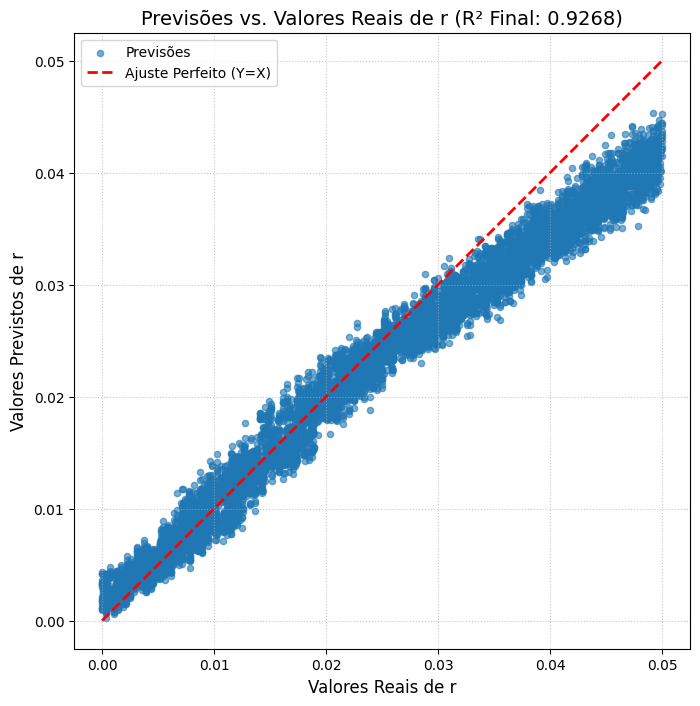

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que você já tem:
# y_true_original: valores verdadeiros de 'r' (na escala original)
# y_pred_original: valores previstos de 'r' (na escala original)

# Crie a linha de identidade X=Y
min_val = min(y_train.min(), y_pred_original.min())
max_val = max(y_train.max(), y_pred_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_train, y_pred_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {final_r2:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

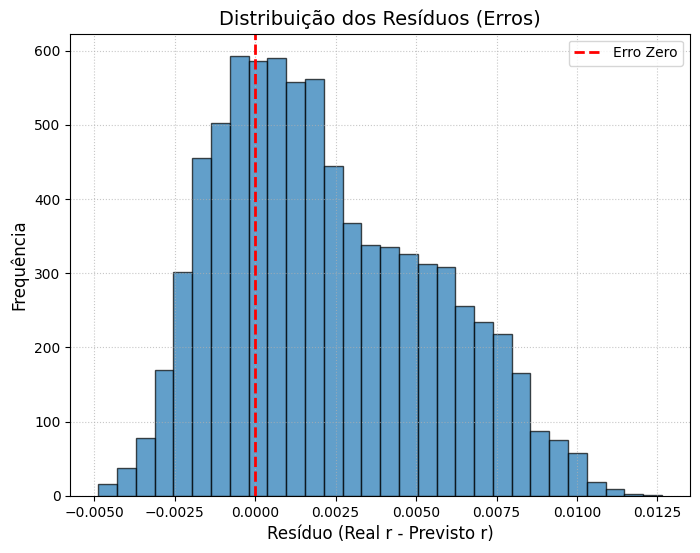

In [30]:
# Calcule os resíduos (True - Predicted)
residuals = y_true - y_pred_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [31]:
# --- PREPARAÇÃO ---
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_true_flat = y_true.ravel()
y_pred_flat = y_pred_original.ravel()

df_results = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_true')['y_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_true', 'y_pred_mean', 'y_pred_std']


# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_pred_std_safe'] = df_grouped['y_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_true'] - df_grouped['y_pred_mean']) / df_grouped['y_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

Dados Agrupados (Exemplo):
     y_true  y_pred_mean  y_pred_std  y_pred_std_safe  Standardized_Residual
0  0.000000     0.003599    0.000468         0.000468               7.689092
1  0.000028     0.001489    0.000408         0.000408               3.581607
2  0.000103     0.002249    0.000389         0.000389               5.513198
3  0.000185     0.001439    0.000217         0.000217               5.772106
4  0.000229     0.002621    0.000540         0.000540               4.429022


## Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

Uma forma mais útil de visualizar os dados é portanto colapsar os 10 dados referentes à cada valor do target em seu valor médio e desvio padrão.

Além disso, plota-se gráfico de resíduos padronizados, que ajuda  visualizar o número de observações que se distanciam do valor real em mais de um desvio-padrão.



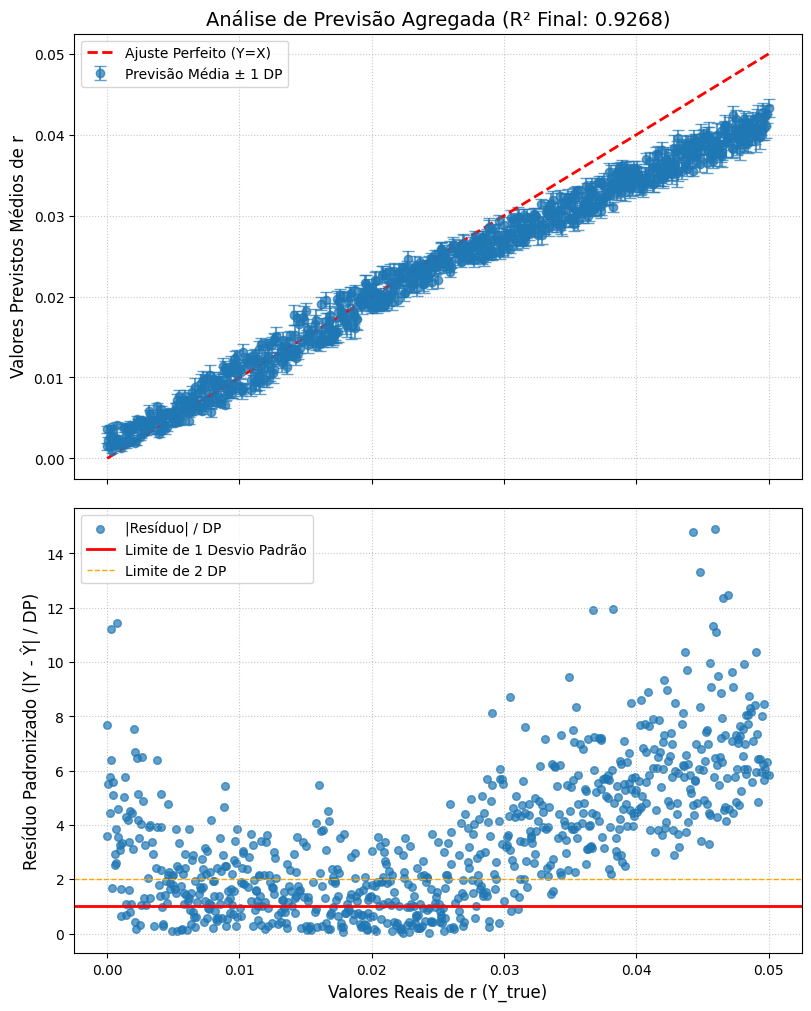

In [32]:
# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_true'],             
    y=df_grouped['y_pred_mean'],            
    yerr=df_grouped['y_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {final_r2:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_true'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r (Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()

## Obsevação

- Houve uma melhora nas métricas, mas fica evidente nas visualizações acima que houve uma piora nas previsões para valores muito baixo do target 'r'.

- O modelo tende a errar mais para valores de r próximos de 0. 

# 5 - Aplicando o modelo no conjunto de teste

In [33]:
teste = pd.read_csv('../data/02_intermediate/teste_b_df.csv')

In [34]:
teste

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,r
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.012381
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.012381
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.012381
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.012381
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.012381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.014936
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.014936
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.014936
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.014936


In [35]:
X_test = teste.drop(columns=['r'])
y_test = teste['r']

## 5.1 - Criando features extras

Todas as features criadas para treinar o modelo devem também ser criadas ao se aplicar os dados de teste. 

In [36]:
X_test = utils.cria_feature_media_ponderada(X_test)

In [37]:
X_test

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,media_ponderada_Cls
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.000110
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.000109
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.000110
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.000110
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.000102
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.000103
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.000102
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.000102


## 5.2 - Selecionando features

In [38]:
X_test = X_test[selected_feature_names]

## 5.3 - Normalizando os dados de teste 

In [39]:
X_test_scaled = X_scaler.fit_transform(X_test)

# Escalonamento do Target (Y)
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scaler.fit_transform(y_test_2d)

In [40]:
X_test_scaled

array([[0.22200547, 0.21137358, 0.22325121, ..., 0.25024548, 0.28243636,
        0.29890806],
       [0.21123043, 0.14058711, 0.20829578, ..., 0.27508063, 0.14490955,
        0.23171529],
       [0.094477  , 0.30160316, 0.29073073, ..., 0.30043211, 0.24110827,
        0.31722308],
       ...,
       [0.17706824, 0.23754371, 0.20433848, ..., 0.3376564 , 0.20673423,
        0.29168525],
       [0.25434185, 0.20228553, 0.17550449, ..., 0.37830535, 0.3003209 ,
        0.21579562],
       [0.25276705, 0.2752049 , 0.26833414, ..., 0.20212627, 0.26123371,
        0.29082958]], shape=(2000, 30))

In [41]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [42]:
X_test_scaled.min()

np.float64(0.0)

In [43]:
# Obtem o melhor modelo do Halving Random Search
best_nn_model = hrs_result.best_estimator_

# A previsão é feita na escala Z-Score (escalada)
y_pred_test_scaled = best_nn_model.predict(X_test_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_test_original = y_scaler.inverse_transform(y_pred_test_scaled)


print("Previsão no Conjunto de Teste concluída com sucesso.")

Previsão no Conjunto de Teste concluída com sucesso.


In [44]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [45]:
y_pred_test_scaled.max()

np.float32(0.96681863)

In [46]:
X_test_scaled.min()

np.float64(0.0)

In [47]:
y_pred_test_scaled.min()

np.float32(-0.0056621134)

In [48]:
y_pred_test_original.max()

np.float32(0.048267905)

In [49]:
y_pred_test_original.min()

np.float32(0.00022930291)

## Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:




In [ ]:
np.save(caminho_X_test_shap_non_linear_features, X_test_scaled)

np.save(caminho_y_test_shap_non_linear_features, y_test_scaled)

## 5. 4 - Visualizando métricas

In [50]:
# Cálculo das 3 Métricas de Avaliação Finais:
mse_test = mean_squared_error(y_test_2d, y_pred_test_original)
rmse_test = root_mean_squared_error(y_test_2d, y_pred_test_original)
mae_test = mean_absolute_error(y_test_2d, y_pred_test_original)
r2_test = r2_score(y_test_2d, y_pred_test_original)

print("\n" + "="*50)
print("AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE")
print("="*50)
print(f"MSE (Erro Quadrático Médio): {mse_test:.8f}")
print(f"RMSE (Erro Absoluto Médio):   {rmse_test:.8f} (Erro médio na unidade de 'r')")
print(f"MAE (Erro Absoluto Médio):   {mae_test:.8f} (Erro médio na unidade de 'r')")
print(f"R2 (Ajuste):                 {r2_test:.4f}")
print("="*50)


AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE
MSE (Erro Quadrático Médio): 0.00001033
RMSE (Erro Absoluto Médio):   0.00321353 (Erro médio na unidade de 'r')
MAE (Erro Absoluto Médio):   0.00246776 (Erro médio na unidade de 'r')
R2 (Ajuste):                 0.9495


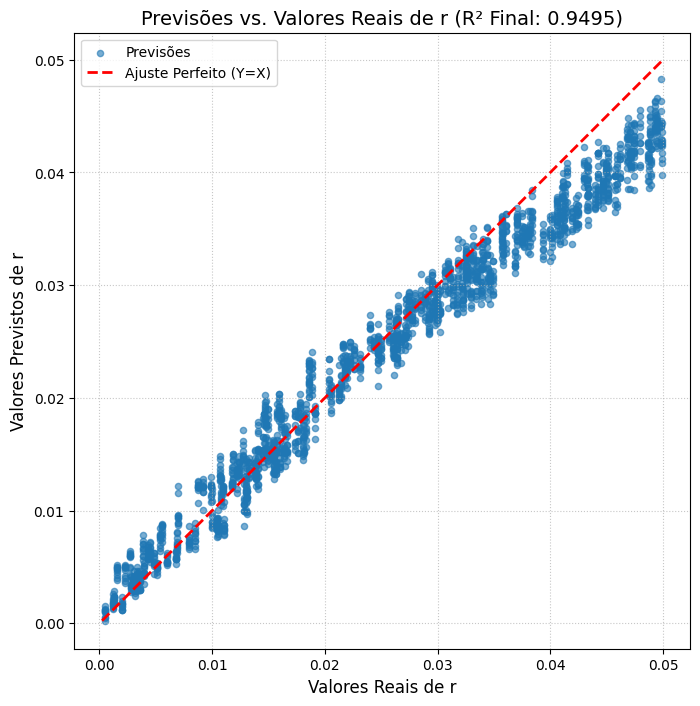

In [51]:
# Crie a linha de identidade X=Y
min_val = min(y_test_2d.min(), y_pred_test_original.min())
max_val = max(y_test_2d.max(), y_pred_test_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_test_2d, y_pred_test_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {r2_test:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

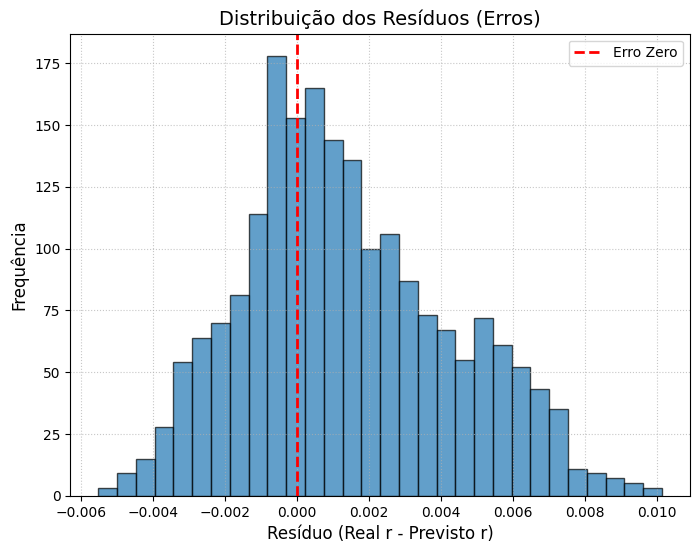

In [52]:


# Calcule os resíduos (True - Predicted)
residuals = y_test_2d - y_pred_test_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## 5.5 - Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

A visualização com barras de erros também é feita abaixo utilizando-se os dados de teste.

In [53]:
# --- PREPARAÇÃO ---
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_test_flat = y_test_2d.ravel()
y_pred_test_flat = y_pred_test_original.ravel()

df_results = pd.DataFrame({
    'y_test': y_test_flat,
    'y_test_pred': y_pred_test_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_test')['y_test_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_test', 'y_test_pred_mean', 'y_test_pred_std']

# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_test_pred_std_safe'] = df_grouped['y_test_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_test'] - df_grouped['y_test_pred_mean']) / df_grouped['y_test_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

Dados Agrupados (Exemplo):
     y_test  y_test_pred_mean  y_test_pred_std  y_test_pred_std_safe  \
0  0.000509          0.000945         0.000399              0.000399   
1  0.001191          0.001781         0.000386              0.000386   
2  0.001256          0.002225         0.000313              0.000313   
3  0.001547          0.004644         0.000435              0.000435   
4  0.001983          0.001599         0.000383              0.000383   

   Standardized_Residual  
0               1.091671  
1               1.528642  
2               3.092751  
3               7.124608  
4               1.002351  


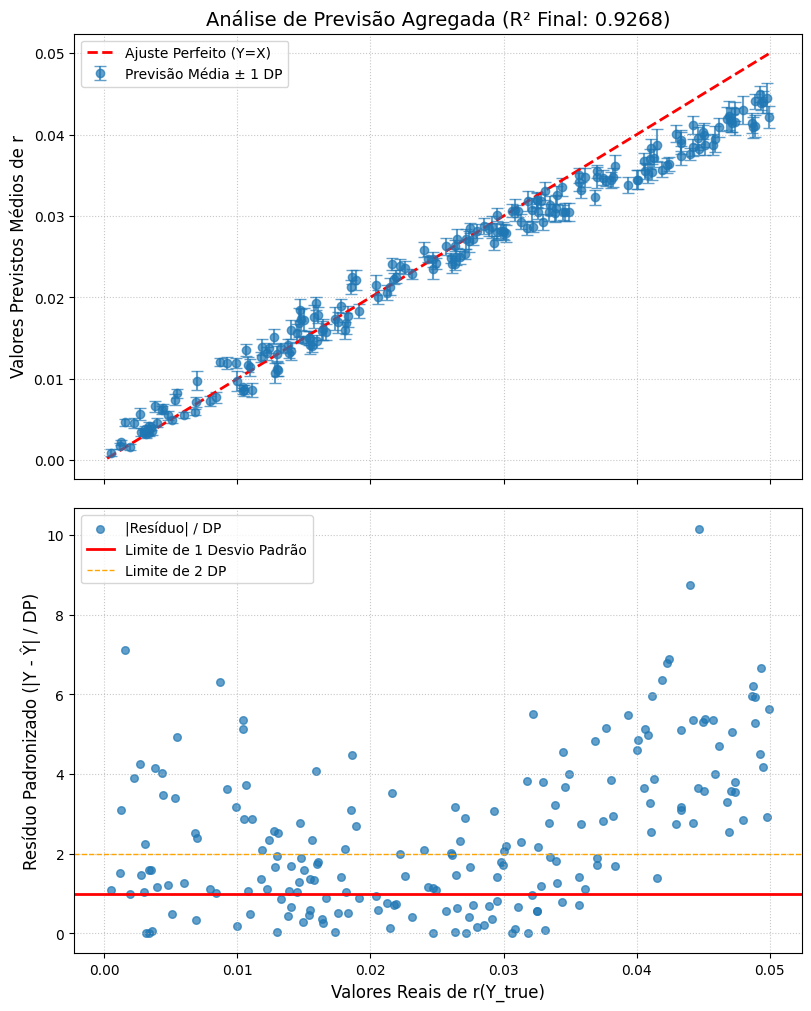

In [54]:
# --- VISUALIZAÇÃO COM GRÁFICO DE DUPLO EIXO ---

# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_test'],             
    y=df_grouped['y_test_pred_mean'],            
    yerr=df_grouped['y_test_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {final_r2:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_test'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r(Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()

## 5.6 - Observação

- Ao utilizarmos as 300 features mais importantes de acordo com o teste estatístico feito com o método da classe SelectKBest do scikit-learn, houve uma piora nas métricas do modelo. Principalmente na região inferior do eixo x, onde  r < 0.02.



# 6 - Explicabilidade

Os gráficos SHAP (SHapley Additive exPlanations) são uma boa forma de visualizar a importancia das features utilizadas e tirar insights de como as features estão ajudando o modelo a prever o target.

Plota-se abaixo alguns gráficos SHAP para se obter mais insights sobre as features e seu impacto na predição do target.

Os gráficos são salvos na pasta data/08_reporting.

In [55]:
if existing_model_shap:
    # Carregar os valores salvos
    shap_values = np.load(caminho_shap, allow_pickle=True)
    X_test_scaled = np.load(caminho_X_test_shap, allow_pickle=True)
    with open(caminho_explainer, 'rb') as f:
        expected_value = pickle.load(f)

else:

    # O KernelExplainer usa um "background dataset" para calcular a linha de base.
    # Recomenda-se usar uma pequena amostra aleatória dos dados de treino ou teste.
    X_background = shap.sample(X_train_scaled, 100) # Amostra de 100 observações

    # --- Definir o Explainer ---
    # O KernelExplainer funciona com qualquer modelo, mas requer uma função preditiva.
    # Assumindo que seu modelo se chama 'model_rn'
    explainer = shap.KernelExplainer(
        best_nn_model.predict, 
        X_background
    )

    # --- Calcular os Valores SHAP ---
    # Calcule os valores para o seu conjunto de teste (X_test_final).
    # Isso pode ser demorado (pode levar minutos ou horas, dependendo do tamanho de X_test_final)
    shap_values = explainer.shap_values(X_test_scaled)

2025-10-20 15:12:12.608084: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  0%|          | 0/2000 [00:00<?, ?it/s]

2025-10-20 15:12:19.553164: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-10-20 15:12:25.513383: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

## 6.1 - Gráfico de Resumo Global (Summary Plot - Importância das Features)

Este é o gráfico mais importante e mostra a importância global das features.

    - Eixo Y: Features ordenadas por importância.

    - Eixo X: Valor SHAP.

    - Cor: Valor da feature (azul = baixo valor da feature, vermelho = alto valor da feature).

In [56]:
X_test

,l_46,l_49,l_50,l_51,l_52,l_53,l_54,l_55,l_56,l_57,...,l_68,l_69,l_70,l_71,l_72,l_73,l_74,l_76,l_78,l_79
0,0.001075,0.001067,0.001193,0.001424,0.001013,0.001267,0.001121,0.001013,0.001327,0.001137,...,0.001616,0.001977,0.001875,0.001504,0.001570,0.001485,0.001466,0.001593,0.001811,0.001766
1,0.001043,0.000867,0.001142,0.001033,0.000889,0.000928,0.001349,0.001215,0.001392,0.001402,...,0.001457,0.001308,0.001262,0.001608,0.001447,0.001362,0.001718,0.001673,0.001350,0.001550
2,0.000693,0.001323,0.001422,0.000926,0.001119,0.001557,0.001370,0.001408,0.000971,0.000997,...,0.001895,0.001304,0.001522,0.001873,0.001580,0.001944,0.001661,0.001755,0.001672,0.001824
3,0.001066,0.000898,0.001089,0.001088,0.001553,0.001029,0.001280,0.001480,0.001273,0.001280,...,0.001775,0.001582,0.001623,0.001948,0.001763,0.001669,0.001714,0.001314,0.001801,0.001624
4,0.000789,0.001024,0.001331,0.000861,0.001285,0.001232,0.001280,0.001177,0.000951,0.001547,...,0.001442,0.001693,0.001772,0.001336,0.001928,0.001458,0.001723,0.001662,0.001617,0.001715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000919,0.001152,0.001479,0.000933,0.001454,0.001459,0.001042,0.001030,0.001336,0.001357,...,0.001329,0.001633,0.001411,0.001436,0.002218,0.001535,0.001606,0.001790,0.001710,0.001559
1996,0.001208,0.001031,0.000965,0.001638,0.001075,0.001363,0.001194,0.001407,0.001371,0.000930,...,0.002146,0.001273,0.001607,0.001997,0.001543,0.001537,0.001952,0.001724,0.001921,0.001803
1997,0.000940,0.001142,0.001129,0.001316,0.001090,0.001226,0.001252,0.001243,0.001314,0.001308,...,0.001674,0.001345,0.001526,0.001454,0.002140,0.001863,0.001628,0.001874,0.001557,0.001742
1998,0.001172,0.001042,0.001031,0.001254,0.001456,0.001201,0.000920,0.001589,0.001161,0.001488,...,0.001513,0.001687,0.001444,0.001668,0.001505,0.001451,0.001794,0.002005,0.001871,0.001498


In [57]:
feature_names=X_test.columns.tolist()

In [58]:
feature_names

['l_46',
 'l_49',
 'l_50',
 'l_51',
 'l_52',
 'l_53',
 'l_54',
 'l_55',
 'l_56',
 'l_57',
 'l_58',
 'l_59',
 'l_60',
 'l_61',
 'l_62',
 'l_63',
 'l_64',
 'l_65',
 'l_66',
 'l_67',
 'l_68',
 'l_69',
 'l_70',
 'l_71',
 'l_72',
 'l_73',
 'l_74',
 'l_76',
 'l_78',
 'l_79']

In [59]:
# Supondo que você usou o código abaixo para definir shap_values_plot
if isinstance(shap_values, list):
    shap_values_plot = shap_values[0]
else:
    shap_values_plot = shap_values

print(f"Tipo de shap_values_plot: {type(shap_values_plot)}")
print(f"Shape de shap_values_plot: {shap_values_plot.shape}")
print(f"Número de Features esperadas: {len(selected_feature_names)}") # Use o nome da sua lista de features

Tipo de shap_values_plot: <class 'numpy.ndarray'>
Shape de shap_values_plot: (2000, 30, 1)
Número de Features esperadas: 30


Novo Shape de shap_values_plot: (2000, 30)


/tmp/ipykernel_4097/1996715775.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


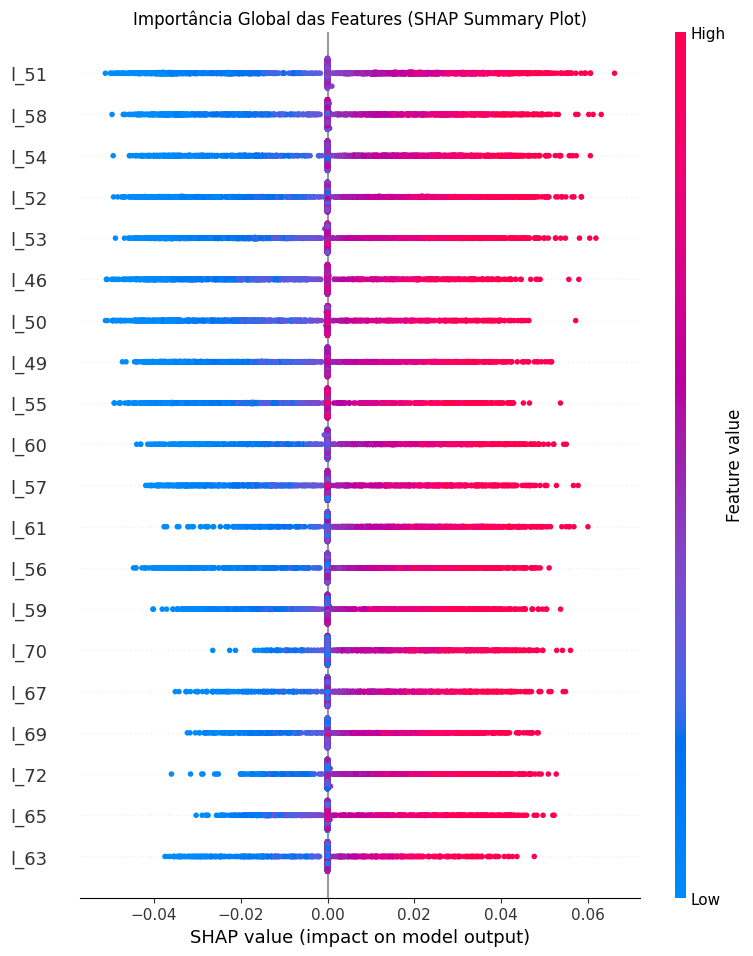

In [60]:
if isinstance(shap_values, list):
    # Pega o primeiro elemento da lista (que é o array (2000, 30, 1))
    shap_values_array = shap_values[0]
else:
    shap_values_array = shap_values

# ACHATA o array de (2000, 30, 1) para (2000, 30)
shap_values_plot = np.squeeze(shap_values_array)

# Verificação após o squeeze 
print(f"Novo Shape de shap_values_plot: {shap_values_plot.shape}") 
# Deve retornar (2000, 30)

# --- Geração do Gráfico ---

shap.summary_plot(
    shap_values_plot, 
    X_test_scaled, # O array de dados (2000, 30)
    feature_names=selected_feature_names,
    show=False 
)
plt.title("Importância Global das Features (SHAP Summary Plot)")
plt.show()

# Salvar a imagem. O formato é determinado pela extensão (.png, .jpg, .pdf, .svg)
plt.savefig(
    '../data/08_reporting/shap_summary_plot.png', 
    dpi=300,        # Alta resolução para qualidade de relatório
    bbox_inches='tight' # Garante que todos os rótulos e eixos sejam incluídos
)
plt.clf() # Limpa o Matplotlib Figure para o próximo gráfico (opcional, mas recomendado)
plt.close() # Fecha a figura (libera memória)

### Explicação do gráfico acima

O Gráfico de Resumo SHAP é a maneira mais concisa de entender a importância e a direção do impacto de cada feature nas previsões.


- Eixo Y: Lista as features (variáveis de entrada), ordenadas da mais importante (topo) para a menos importante (base), com base na magnitude média dos seus valores SHAP.

- Eixo X: Representa o Valor SHAP. Este valor indica a contribuição (positiva ou negativa) de uma feature para a previsão do modelo em relação ao valor de previsão base (média).

- Cor do Ponto: Representa o valor real da feature para aquela observação. Geralmente, Vermelho = Alto Valor da Feature (Alto na escala escalada) e Azul = Baixo Valor da Feature (Baixo na escala escalada).

- Dispersão dos Pontos,Cada ponto é uma observação individual do conjunto de teste. A dispersão horizontal mostra o quão variável é o impacto dessa feature entre as observações. Quanto maior a dispersão de uma feature que já foi avaliada como importante, maior é a interação entre as features do modelo.




### Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

### Interpretação dos Resultados da Observação 0

A previsão de r (0.2748) é significativamente inferior ao valor médio (0.5108).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## 6.2 - Gráfico de Força (Force Plot - Explicação Local)

O gráfico abaixo explica uma única previsão. Ele mostra como cada feature empurra a previsão da linha de base (valor médio) para o valor final previsto.

In [61]:
observation_index = 0
X_test_scaled[observation_index:observation_index+1]

array([[0.22200547, 0.21137358, 0.22325121, 0.32577575, 0.18488168,
        0.23740614, 0.20680809, 0.13376455, 0.25150128, 0.1709436 ,
        0.21756154, 0.17902226, 0.2372875 , 0.17655513, 0.30037873,
        0.17916029, 0.23035571, 0.18015026, 0.28507387, 0.26328434,
        0.2630134 , 0.38646146, 0.36463916, 0.22627463, 0.25501688,
        0.21537819, 0.19581698, 0.25024548, 0.28243636, 0.29890806]])

In [62]:
feature_names

['l_46',
 'l_49',
 'l_50',
 'l_51',
 'l_52',
 'l_53',
 'l_54',
 'l_55',
 'l_56',
 'l_57',
 'l_58',
 'l_59',
 'l_60',
 'l_61',
 'l_62',
 'l_63',
 'l_64',
 'l_65',
 'l_66',
 'l_67',
 'l_68',
 'l_69',
 'l_70',
 'l_71',
 'l_72',
 'l_73',
 'l_74',
 'l_76',
 'l_78',
 'l_79']

2025-10-20 18:32:51.609982: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Explicação para a Observação 0:
Valor Base (Média): 0.4457
Valor Previsto: 0.2794


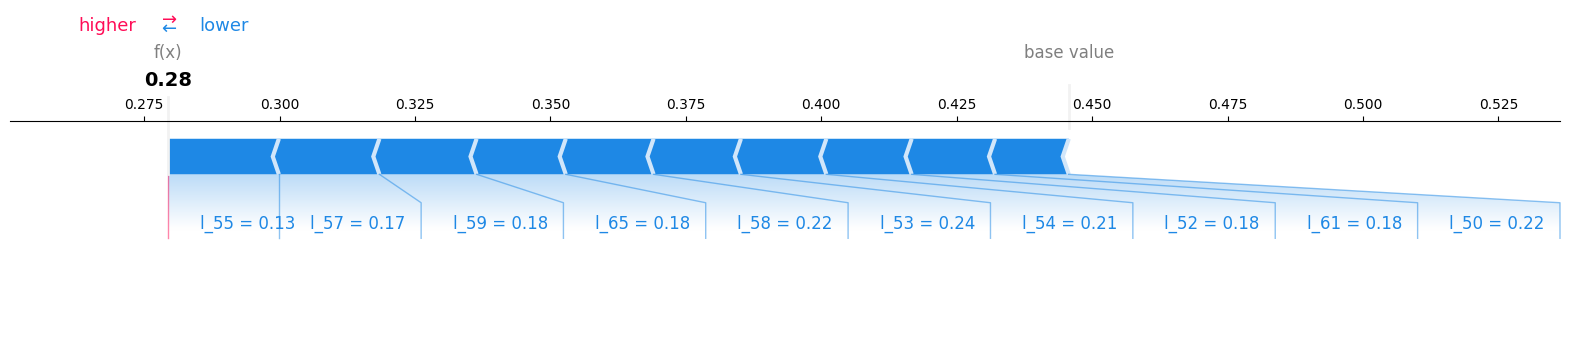

In [63]:
# Le o modelo caso ele já exista
if existing_model_shap:
    best_nn_model = joblib.load(caminho_modelo)

observation_index = 0

# Acessa os valores da feature (a linha de dados)
# Funciona para NumPy Array e Pandas DataFrame/Series
if hasattr(X_test_scaled, 'iloc'):
    # Se for DataFrame, pega a linha como Series para o Force Plot
    X_obs_values_raw = X_test_scaled.iloc[observation_index]
else:
    # Se for Array NumPy, apenas pega a linha (será um array 1D)
    X_obs_values_raw = X_test_scaled[observation_index]


# ARREDONDAR PARA DUAS CASAS DECIMAIS
X_obs_values = np.round(X_obs_values_raw, 2)

# --- 2. Preparação para Print e Predição ---

# Para predição, o modelo sempre espera uma entrada 2D (mesmo para 1 observação)
X_obs_for_prediction = X_test_scaled[observation_index:observation_index+1]
predicted_value = best_nn_model.predict(X_obs_for_prediction)[0]

print(f"\nExplicação para a Observação {observation_index}:")
print(f"Valor Base (Média): {explainer.expected_value[0]:.4f}") # Formata o valor base
print(f"Valor Previsto: {predicted_value[0]:.4f}") # Formata o valor previsto


# --- 3. Geração e Salvamento do Force Plot ---

# shap_values_plot[observation_index] é o array 1D dos valores SHAP para esta observação
shap.force_plot(
    explainer.expected_value,
    shap_values_plot[observation_index],
    X_obs_values, # Os valores da feature para a observação
    feature_names=selected_feature_names, # Passe a lista de nomes explicitamente
    matplotlib=True,
    #show=False
)

# Salvar a figura atual do Matplotlib
plt.savefig(
    f'../data/08_reporting/shap_force_plot_obs_{observation_index}.png', 
    dpi=300, 
    bbox_inches='tight'
)
plt.clf()
plt.close()

## Explicação do gráfico acima

O Force Plot (Gráfico de Força) fornece uma explicação local, detalhando exatamente como cada feature da Observação 0 contribuiu para a previsão final do modelo.

A observação 0 é a primeira linha do dataset.

- Valor Base (Média): 0.5108,
    - Significado: É a previsão média de r (ou a média dos targets escalados) para todo o conjunto de dados. Representa o ponto de partida do modelo antes de considerar as features específicas da observação.
- Valor Previsto: 0.2748
    - Significado: É o valor final previsto para r pelo modelo, após considerar todas as features específicas da Observação 0."

## Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

## Interpretação dos Resultados da Observação 0

A previsão de r (0.2748) é significativamente inferior ao valor médio (0.5108).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## Observação

- Um valor longe do valor médio, como mostrado no gráfico acima, não indica que o resultado foi ruim.

- Podemos ver nas linhas de código abaixo que o valor `y_test_scaled`, que é o valor real, ficou próximo do valor previsto pelo modelo.

In [64]:
y_test[0]

np.float64(0.012381)

In [65]:
y_test_scaled[0]

array([0.24033362])

## 6.3 - Gráfico de Dependência (Dependence Plot - Relação Feature-Target)

O Gráfico de Dependência SHAP (SHAP Dependence Plot) é projetado para mostrar como a relação entre uma feature específica e o resultado do modelo se parece. Em essência, é uma versão explicável do tradicional gráfico de dispersão, ajudando a visualizar a forma (linear, não linear, ou complexa) que o modelo aprendeu para essa variável.

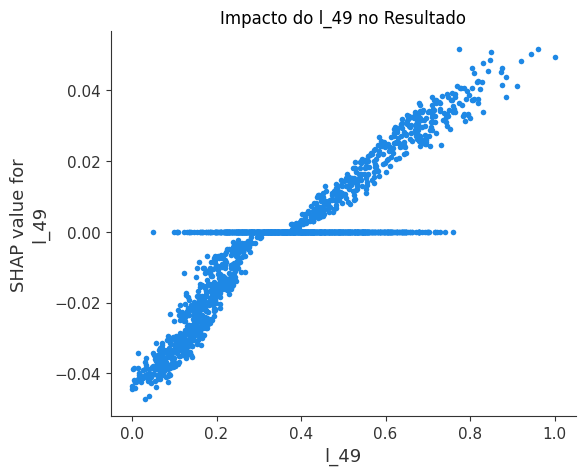

In [66]:
# Explicando a relação da feature mais importante 
most_important_feature = 'l_49' # Substitua pelo nome da sua feature principal

shap.dependence_plot(
    most_important_feature, 
    shap_values_plot, 
    X_test_scaled, 
    interaction_index=None, # Não mostra interação com outra feature
    show=False,
    feature_names=selected_feature_names
)
plt.title(f"Impacto do {most_important_feature} no Resultado")
plt.show()


plt.savefig(
    f'../data/08_reporting/shap_dependence_plot_{most_important_feature}.png', 
    dpi=300, 
    bbox_inches='tight'
)
plt.clf()
plt.close()

## Explicação do gráfico acima

- Eixo Y: Valor SHAP da Feature de interesse. Representa a contribuição real (o peso) que essa feature adiciona ou subtrai da previsão do modelo para aquela observação.
- Eixo X: Valor Real da Feature de interesse (most_important_feature). Mostra o valor escalado da variável.
- Pontos: Cada ponto é uma observação individual do seu conjunto de teste.
- Ausência de Cor: Com o interaction_index=None, os pontos não são coloridos por uma segunda feature. Eles refletem apenas a relação direta entre a feature de interesse e seu próprio impacto SHAP.

## Como interpretar

Ao analisar este gráfico, examina-se a forma da nuvem de pontos para entender a lógica do modelo.

1. Relação Linear (Fácil de Interpretar)

    Padrão: Os pontos formam uma linha reta ou tendem a seguir uma inclinação clara (seja positiva ou negativa).

    Exemplo: Se, à medida que o valor da feature no Eixo X aumenta, o Valor SHAP no Eixo Y também aumenta (subindo da esquerda para a direita).

    Conclusão: O modelo aprendeu uma relação linear simples: um aumento constante no valor da feature leva a um aumento constante na previsão.

2. Relação Não Linear (Comum em Redes Neurais)

    Padrão: Os pontos formam uma curva (ex: curva U, curva S invertida).

    Exemplo: O Valor SHAP é baixo para valores extremos da feature (X baixo e X alto), mas o Valor SHAP se eleva significativamente para valores intermediários da feature.

    Conclusão: O modelo aprendeu que o impacto da feature não é constante. Por exemplo, a variável é importante apenas dentro de um certo limite ótimo (o "sweet spot").

3. Dispersão Vertical (Ruído e Interações Remotas)

    Padrão: Em um valor específico no Eixo X (por exemplo, quando o valor da feature é 0.5), você vê os pontos dispersos verticalmente (ou seja, diferentes Valores SHAP).

    Conclusão: Isso indica que, mesmo com o mesmo valor para a feature de interesse, seu impacto na previsão muda dependendo dos valores de outras features no modelo (as que você não está colorindo). O efeito é complexo e está sendo influenciado por interações de ordem superior que o modelo capturou.

O Dependence Plot é uma ferramenta poderosa para validar se o modelo está aprendendo relações que fazem sentido no domínio do problema. Por exemplo, se uma relação linear é esperada e o gráfico mostra uma relação não linear, isso sugere que a Rede Neural descobriu uma dinâmica mais sutil nos seus dados. 

## Interpretação do gráfico gerado

- O modelo aprendeu uma relação quase linear para essa feature, onde a contribuição marginal é mais significativa nas extremidades. Os Valores SHAP nulos na faixa intermediária da feature indicam que, nesse ponto, o efeito da feature sobre a previsão é neutro, ou seja, ele não contribui nem positivamente nem negativamente em relação à previsão média do modelo.



# 7 - Salvando os valores SHAP para reutilizá-los no futuro

In [ ]:
import numpy as np
import pickle # Para salvar o Explainer (opcional, mas útil)

# Salvar os shap_values
np.save(caminho_shap, shap_values)

# Salvar o background data e o expected_value (opcional, mas útil para o Force Plot)
np.save(caminho_X_test_shap_non_linear_features, X_test_scaled)
with open(caminho_explainer, 'wb') as f:
    pickle.dump(explainer.expected_value, f)

# 8 - Sugestões para trabalhos futuros

- Fazer uma seleção de features utilizando-se um modelo linear ao invés do método estatístico utilizado pela classe SelectKBest.

- Testar o resultado do modelo eliminando menos features.

- Criar novas features com os dados de entrada.

- Aumentar a rede de parâmetros da validação cruzada.